# Document classification

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2017 Florian Leitner. All rights reserved.

## Introduction

Today's lab will cover the two most fundamental techniques of Text Mining: Document classification and indexing; This notebook covers the former.

First we run the standard setup seen in the preparatory notebooks:

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


Ensure you have **SciKit-Learn** installed or install it with:

- Anaconda Python: `conda install sklearn`
- Stock Python: `pip3 install sklearn`

Once installed, the following import should work:

In [2]:
import sklearn

## Corpus setup

The de facto standard evaluation dataset of Text Mining (analgous to the  [MINST "database" of handwritten digits](http://yann.lecun.com/exdb/mnist/) for computer vision) is the [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) (from 1997 - yes, its vocabulary is outdated...).

In [3]:
from sklearn.datasets import fetch_20newsgroups
help(fetch_20newsgroups)

Help on function fetch_20newsgroups in module sklearn.datasets.twenty_newsgroups:

fetch_20newsgroups(data_home=None, subset='train', categories=None, shuffle=True, random_state=42, remove=(), download_if_missing=True)
    Load the filenames and data from the 20 newsgroups dataset (classification).
    
    Download it if necessary.
    
    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality               1
    Features                  text
    =================   ==========
    
    Read more in the :ref:`User Guide <20newsgroups_dataset>`.
    
    Parameters
    ----------
    data_home : optional, default: None
        Specify a download and cache folder for the datasets. If None,
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    subset : 'train' or 'test', 'all', optional
        Select the dataset to load: 'train' for the training set, 'test'
        for the test set, 'all' f

Download and perpare the dataset (needs a working internet connection):

In [4]:
train = fetch_20newsgroups()
test = fetch_20newsgroups(subset='test')

Display some information about our corpus: n. documents, corpus size (characters), n. labels (newsgroups).

In [5]:
def nmmchars(docs):
    return sum(map(len, docs)) / 1e6

print("Training set:",
      " %5d documents with %4.1f million UTF-16 characters" % (
    len(train.data), nmmchars(train.data)))
print("Test set    :", 
      "%5d documents with %4.1f million UTF-16 characters" % (
    len(test.data), nmmchars(test.data)))

print("\n%d Newsgroups:" % len(train.target_names))
print('\n'.join(train.target_names))

Training set:  11314 documents with 22.1 million UTF-16 characters
Test set    :  7532 documents with 13.8 million UTF-16 characters

20 Newsgroups:
alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


An example document (NB: *always* **look at your data** - I could not emphasise this more!):

In [6]:
print(train.data[0].strip())

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----


Extract the label vectors $y_{train}$ and  $y_{test}$ for the training and test set (as integers referencing the newsgroups):

In [7]:
y_train, y_test = train.target, test.target
print(y_train)
print(y_test)

[7 4 4 ... 3 1 8]
[ 7  5  0 ...  9  6 15]


## Vectorizing text

Due to using SciKit-Learn, we get *everything* we discussed in the lecture (and some more) in one nice package: 

- A simple$^§$ regex-based tokenization: `(?u)\\b\\w\\w+\\b`,
- English stop-word filtering (other langauges: provide your own list), 
- Lower-case text normalization,
- Vocabulary selection (limit the vocabulary to a predefined set),
- Word n-gram ("term") generation (**default: none**!),
- Inverted (term) indexing, and
- TF-IDF term weighting

from the **[`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)**. In fact, this class even provides several niceties we are not using: character decoding, removal of accents, and even *character* n-gram feature generation (as opposed to token ("word") n-grams).

$^§$ You might want to replace the default regex with: `(?u)(?:\\b|(?<=_))[^\W_][^\W_]+(?:\\b|(?=_))` to avoid having underscores in words (except maybe when analyzing Twitter tweets).

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
help(TfidfVectorizer.__init__)

Help on function __init__ in module sklearn.feature_extraction.text:

__init__(self, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
    Initialize self.  See help(type(self)) for accurate signature.



### TF-IDF parameters

The parameters that control TF-IDF term weighting are:

#### `binary`, Boolean, `True`

Only 0/1 counts for words: aka, in document or not.
Despite possible doubts, this often works surprisingly well, because it is a strong *regularization technique*.

#### `max_df`, $(0.0,1.0]$, `1.0`

Remove words in more documents than the `max_df` proportion.
Think: "learning corpus-specific, automatic stop-word filtering";
If your corpus is large enough (thousands or more documents), use this feature instead of brewing up your own stop-word list!
Sometimes even including a stop-word list might lead you to filter out some of your best features.
But as always in machine learning: The best strategy is to evaluate all approaches (i.e., with and without stop-words and/or DF filtering).
Good values are in the range of $[0.25, 0.75]$, depending on corpus size.

#### `min_df`, $[1,∞)$, `1`

Filter (remove) words that appear in less than `min_df` documents.
This again is regularization technique and can help remove noise.
A good default value for this option is in the range of $[3,5]$, depending on corpus size (and possibly even `2` or even `10` for extreme sizes).

#### `use_idf`, Boolean, `True`

Dis- or enable IDF re-weighting (possibly only using term frequency).
This option is particularly useful if you want to apply TF scaling (only) and/or other functionality of this vectorizer for some other means (than document classificiation/clustering).
Also, for a **small training set**, IDF scaling might introduce more noise than anything else, in which case you also want to disable IDF.

#### `smooth_idf`, Boolean, `True`

If using IDF, add Laplace (aka. lidstone) +1 smoothing to all document frequency counts, to avoid divide-by-zero errors (i.e., assume each word was seen at least once at all times).
The default is `True`, but you can use `False` if you then limit your (*test set*) vocabulary (i.e., "for prediction") to the words seen during training;
I.e., if you have a **small dataset** (with hundreds or less documents), set this parameter to `False` and only work with the words "seen" during training (aka, your "vocabulary").


#### `sublinear_tf`, Boolean, `False`

Apply logarthimic scaling to term frequencies.
Ironically, the default is `False`, but you almost always want to use this (*except* for **tiny training datasets** with dozens or less documents, *possibly* (do evaluate that assumption first!)), so remember to **use `True` by default**!

### Setup and vecorization

With the above in mind, a good default setup for our corpus "dimensions" might be (feel free to play around with this setup and see if you can increase the end-result!):

In [9]:
%%time
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.5,
    #ngram_range=(1,2),
    #token_pattern='(?u)(?:\\b|(?<=_))[^\W_][^\W_]+(?:\\b|(?=_))',
)
# train (aka, fit) the vectorizer to the train data:
X_train = vectorizer.fit_transform(train.data)
# with the fitted vectorizer, transform the test data:
X_test = vectorizer.transform(test.data)

CPU times: user 5.07 s, sys: 80.4 ms, total: 5.15 s
Wall time: 5.15 s


In [10]:
X_test

<7532x38842 sparse matrix of type '<class 'numpy.float64'>'
	with 927875 stored elements in Compressed Sparse Row format>

If your machine isn't very old, all this "text-to-numbers" (vectors) setup should have not taken more than a few seconds.
The most time-consuming factor in the above setup is the n-gram range.

In [11]:
import random

feature_names = vectorizer.get_feature_names()

# look at some random features ("terms")
print("\n".join(sorted(random.sample(feature_names, 20))))
#print()
# first n
#print("\n".join(feature_names[:5]))
# last n
#print("\n".join(feature_names[-5:]))
# problems:
#print()
#print("\n".join(n for n in feature_names if "__" in n))

feature_names = np.asarray(feature_names)

0o
146
1d
3v9f9d
8076
8d
buslogic
career
dripping
feather
gurion
helen
jafoust
missouri
prototypes
ringer
sch
stekt6
wustl
zah


If you run this frequently enough, you should see that tokenization could have been a bit better... E.g., filtering out all the underscore "separators". Also, sorting your features and looking at the first/last few also often helps identify issues (here, e.g., all the numbers, which might lead to overfitting).

## Classifying text

Now that we have a numeric representation of our text, let's train some machine learning classifiers with it!
As the remainder of the ASDM courses should give you a pretty good feeling for most of the issues of classifiers, we won't detail their setups here.
Also, SciKit-Learn itself has pretty good [tutorials](http://scikit-learn.org/stable/supervised_learning.html) on all these (supervised) classifiers.

The following setup and test-run accross a whole bunch of possible classifiers is taken from the [SciKit-Learn document classification tutorial](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html), with some minor modifications and updates (to remove deprecation warnings).

In [12]:
from time import time

from sklearn import metrics # yay, evaluation metrics! (day 5...)
from sklearn.utils.extmath import density

def trim(s):
    """
    Trim string to fit on terminal
    (assuming 80-column display)
    """
    
    return s if len(s) <= 80 else s[:77] + "..."

def benchmark(clf, adjustments=""):
    print(adjustments, end="")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("\ntrain time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d features" %
              clf.coef_.shape[1])
        print("density: %.1f%% of features used" % 
              (100 * density(clf.coef_)))
        #print("\ntop 10 keywords per class:")
        #for i, label in enumerate(train.target_names):
        #    top10 = np.argsort(clf.coef_[i])[-10:]
        #    print(trim("%s: %s" % (
        #        label, " ".join(feature_names[top10])
        #    )))

    #print("\nclassification report:")
    #print(metrics.classification_report(y_test, pred,
    #                                    target_names=train.target_names))
    #print("\nconfusion matrix:")
    #print(metrics.confusion_matrix(y_test, pred))
    
    print()
    clf_descr = str(clf).split('(')[0]
    return adjustments + clf_descr, score, train_time, test_time

Apply a wide selection of supervised classifiers (this might take a few minutes):

In [13]:
# The SciKit-Learn data processing pipeline:
from sklearn.pipeline import Pipeline
# Using classifiers as feature selectors (in a pipeline):
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"),
         "Ridge Classifier"),
        (Perceptron(max_iter=50),
         "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10),
         "kNN"),
        (RandomForestClassifier(n_estimators=100),
         "Random forest")):
    print('=' * 80)
    results.append(benchmark(clf))

for penalty in ["l2 ", "l1 "]:
    
    print('=' * 80)
    classifier = LinearSVC(
        loss='squared_hinge',
        penalty=penalty.strip(),
        dual=False,
        tol=1e-3)
    results.append(benchmark(classifier, penalty.upper()))
    
    print('=' * 80)
    classifier = SGDClassifier(
        alpha=.0001,
        max_iter=50,
        penalty=penalty.strip())
    results.append(benchmark(classifier, penalty.upper()))

print('=' * 80)
classifier = SGDClassifier(
    alpha=.0001,
    max_iter=50,
    penalty="elasticnet")
results.append(benchmark(classifier, "Elastic "))

print('=' * 80)
results.append(benchmark(NearestCentroid()))

print('=' * 80)
results.append(benchmark(MultinomialNB(alpha=.01)))

print('=' * 80)
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
classifier = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(
      penalty="l1",
      dual=False,
      tol=1e-3))),
  ('classification', LinearSVC())
])
results.append(benchmark(classifier, adjustments="SVC "))

indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)

train time: 5.235s
test time:  0.018s
accuracy:   0.860
dimensionality: 38842 features
density: 100.0% of features used

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

train time: 0.517s
test time:  0.022s
accuracy:   0.808
dimensionality: 38842 features
density: 24.7% of features used

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,

## Results

Plot the historgrams of the classifier performance statistics:

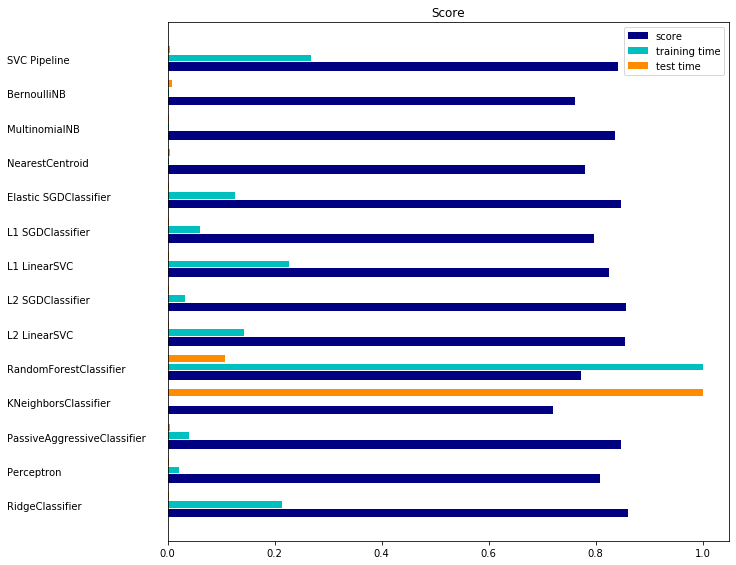

In [14]:
clf_names, score, training_time, test_time = results
training_time_norm = \
    np.array(training_time) / np.max(training_time)
test_time_norm = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .25, label="score", color='navy')
plt.barh(indices + .25, training_time_norm, .2, 
         label="training time", color='c')
plt.barh(indices + .5, test_time_norm, .2,
         label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i+0.1, c)

plt.show()

## Conclusion

In text mining, the classifier often matters much less than *everything else* (tokenization, n-grams, feature selection strategies, etc.), at least if you choose a fairly decent, but still rather simple classifier (here: multinoulli Naive Bayes).

Another set of red flags are the test times of the Random Forset (think: gradient boosting, etc.) and kNN classifiers, i.e., their prohibitively large *prediction times* - at least if you are planning to deploy your classifier in settings where the time it takes to present results (to the user) matters, and the enormous training time of the Random Forest classifier (hint: a deep learning network would be even worse...).